# Assignment 3 - Practical Deep Learning Workshop


#### In this task we will work with the dataset of the Home depot product search relevance competition.
#### Some background: 
In this competition, Home Depot is asking to help them improve their customers' shopping experience by developing a model that can accurately predict the relevance of search results.

Search relevancy is an implicit measure Home Depot uses to gauge how quickly they can get customers to the right products. 

This data set contains a number of products and real customer search terms from Home Depot's website. The challenge is to predict a relevance score for the provided combinations of search terms and products. To create the ground truth labels, Home Depot has crowdsourced the search/product pairs to multiple human raters.
The relevance is a number between 1 (not relevant) to 3 (highly relevant). For example, a search for "AA battery" would be considered highly relevant to a pack of size AA batteries (relevance = 3), mildly relevant to a cordless drill battery (relevance = 2), and not relevant to a snow shovel (relevance = 1).

Each pair was evaluated by at least three human raters. The provided relevance scores are the average value of the ratings. There are three additional things to know about the ratings:
•	The specific instructions given to the raters is provided in relevance_instructions.docx.
•	Raters did not have access to the attributes.
•	Raters had access to product images, while the competition does not include images.


#### Out task here is to predict the relevance for each pair listed in the test set. The test set contains both seen and unseen search terms.


In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import * # Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.regularizers import l2
import re

import pandas as pd
import numpy as np
import datetime
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
 


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### First of all, we'll take a look at the data in each dataset of the input:

train.csv is the training set, contains products, searches, and relevance scores.

In [3]:
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/input/train.csv',encoding='latin1')
train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


test.csv is the test set, contains products and searches. We will need to predict the relevance for these pairs.

In [4]:
test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/input/test.csv',encoding='latin1')
test.head()

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


In [5]:
test_sol = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/input/solution.csv',encoding='latin1')
test_sol.head()

,id,relevance,Usage
0,1,-1.00,Ignored
1,4,2.33,Public
2,5,2.33,Private
3,6,2.67,Private
4,7,2.00,Public


product_descriptions.csv contains a text description of each product. We may join this table to the training or test set via the product_uid.

In [6]:
product_descriptions = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/input/product_descriptions.csv',encoding='latin1')
product_descriptions.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


attributes.csv provides extended information about a subset of the products (typically representing detailed technical specifications). Not every product will have attributes.

In [7]:
attributes = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/input/attributes.csv',encoding='latin1')
attributes.head()

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90Â° connectio...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


Data fields:
- id - a unique Id field which represents a (search_term, product_uid) pair
- product_uid - an id for the products
- product_title - the product title
- product_description - the text description of the product (may contain HTML content)
- search_term - the search query
- relevance - the average of the relevance ratings for a given id
- name - an attribute name
- value - the attribute's value


## Preprocessing the data

We would like to have the products' corresponding product description, so we will merge the train and test datasets with the product_description table.

Note: in order to decrease the dimensionality of the text, we will lower the characters.

In [8]:
mergedTrain = pd.merge(train, product_descriptions, how='inner', on='product_uid')
mergedTrain.search_term = mergedTrain.search_term.apply(lambda x: x.lower())
mergedTrain.product_description = mergedTrain.product_description.apply(lambda x: x.lower())

mergedTrain.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,behr premium textured deckover is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,update your bathroom with the delta vero singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,update your bathroom with the delta vero singl...


In [9]:
mergedTest= pd.merge(test, product_descriptions, how='inner', on='product_uid')
mergedTest.search_term = mergedTest.search_term.apply(lambda x: x.lower())
mergedTest.product_description = mergedTest.product_description.apply(lambda x: x.lower())

mergedTest.head()

,id,product_uid,product_title,search_term,product_description
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"not only do angles make joints stronger, they ..."
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"not only do angles make joints stronger, they ..."
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"not only do angles make joints stronger, they ..."
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"not only do angles make joints stronger, they ..."
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"not only do angles make joints stronger, they ..."


We convert the product_description and search_term attributes' values to lists of characters.

In [0]:
search_term_chars = []
product_description_chars = []
search_term_chars = mergedTrain.search_term.apply(lambda x: search_term_chars + list(x))
product_description_chars = mergedTrain.product_description.apply(lambda x: product_description_chars + list(x))
search_term_chars = [item for sublist in search_term_chars for item in sublist]
product_description_chars = [item for sublist in product_description_chars for item in sublist]


And then, translate the characters to a unique integer values. We create two dictionaries (one for search_term and another for product_description), containing the pairs of characters and their uniquie values. 

In [0]:
search_term_char_set = sorted(set(search_term_chars))
product_description_char_set = sorted(set(product_description_chars))

# translate from character to number, it's enumerator
search_term_char_to_int = dict((c, i) for i, c in enumerate(search_term_char_set))
search_term_int_to_char = dict((i, c) for i, c in enumerate(search_term_char_set))
product_description_char_to_int = dict((c, i) for i, c in enumerate(product_description_char_set))
product_description_int_to_char = dict((i, c) for i, c in enumerate(product_description_char_set))

In [12]:
# summarize the loaded data
n_chars = len(search_term_chars)
n_vocab = len(search_term_char_set)
print("search_term Total Characters: ", n_chars)
print("search_term Total Vocab: ", n_vocab)

n_chars2 = len(product_description_chars)
n_vocab2 = len(product_description_char_set)
print("product_description Total Characters: ", n_chars2)
print("product_description Total Vocab: ", n_vocab2)

search_term Total Characters:  1407926
search_term Total Vocab:  51
product_description Total Characters:  65598457
product_description Total Vocab:  67


In [13]:
mergedTrain.search_term = mergedTrain.search_term.apply(lambda x: list(x))
mergedTrain.product_description = mergedTrain.product_description.apply(lambda x: list(x))
mergedTrain.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,"[a, n, g, l, e, , b, r, a, c, k, e, t]",3.00,"[n, o, t, , o, n, l, y, , d, o, , a, n, g, ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,"[l, , b, r, a, c, k, e, t]",2.50,"[n, o, t, , o, n, l, y, , d, o, , a, n, g, ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,"[d, e, c, k, , o, v, e, r]",3.00,"[b, e, h, r, , p, r, e, m, i, u, m, , t, e, ..."
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,"[r, a, i, n, , s, h, o, w, e, r, , h, e, a, d]",2.33,"[u, p, d, a, t, e, , y, o, u, r, , b, a, t, ..."
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,"[s, h, o, w, e, r, , o, n, l, y, , f, a, u, ...",2.67,"[u, p, d, a, t, e, , y, o, u, r, , b, a, t, ..."


We would like to turn the search_term and the product_description into sequences of unique integers.

In [0]:
def createData(char_to_int, char_arr):
    #seq_length = 100
    dataX = []
    for i in range(0,len(char_arr)):
        dataX.append(char_to_int[char_arr[i]])
    return np.asarray(dataX)

In [15]:
mergedTrain.search_term = mergedTrain.search_term.apply(lambda x: createData(search_term_char_to_int, x))
mergedTrain.product_description = mergedTrain.product_description.apply(lambda x: createData(product_description_char_to_int, x))
mergedTrain.head()


,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,"[24, 37, 30, 35, 28, 0, 25, 41, 24, 26, 34, 28...",3.00,"[52, 53, 58, 0, 53, 52, 50, 63, 0, 42, 53, 0, ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,"[35, 0, 25, 41, 24, 26, 34, 28, 43]",2.50,"[52, 53, 58, 0, 53, 52, 50, 63, 0, 42, 53, 0, ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,"[27, 28, 26, 34, 0, 38, 45, 28, 41]",3.00,"[40, 43, 46, 56, 0, 54, 56, 43, 51, 47, 59, 51..."
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,"[41, 24, 32, 37, 0, 42, 31, 38, 46, 28, 41, 0,...",2.33,"[59, 54, 42, 39, 58, 43, 0, 63, 53, 59, 56, 0,..."
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,"[42, 31, 38, 46, 28, 41, 0, 38, 37, 35, 48, 0,...",2.67,"[59, 54, 42, 39, 58, 43, 0, 63, 53, 59, 56, 0,..."


## The target value - relevance

Each pair was evaluated by at least three human raters. The provided relevance scores are the average value of the ratings. Thus, we would like to see the number of unique values, between 1 and 3. There are 13 unique relevance values in the data sample. We could address the problem as a classification problem, but we want to address the distance from the maximum relevance value, so we will treat this as a regression problem.

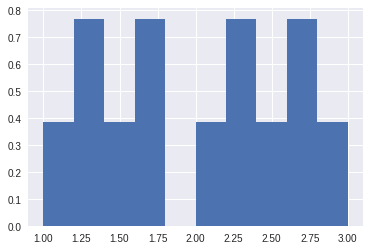

In [16]:
plt.hist(np.unique(mergedTrain.relevance.values),density=True, histtype='bar')
plt.show()

In [17]:
np.unique(mergedTrain.relevance.values).size
          

13

In order to predict the relevance values we need to preprocess the values, and change the range from 1 - 3, to 0 - 1. We want to see the maximum length of each column - the search_term and product_description. We try to limit the char sequences to 75 chars as in the same manner as characters, the lengths of the sequences must be the same in order to unite the data in specified part of the network to enable predictions based on both of these inputs. We also want to see the max sizes of sequences in each column to find the optimal value that will get enough data from both columns.

In [18]:
from sklearn import preprocessing

target = mergedTrain['relevance'].values
min_max_scaler = preprocessing.MinMaxScaler()
Y = min_max_scaler.fit_transform(target.reshape(-1, 1))

Y[:5]


array([[1.   ],
       [0.75 ],
       [1.   ],
       [0.665],
       [0.835]])

In [0]:
X1 = mergedTrain['search_term'].values
X2 = mergedTrain['product_description'].values


In [0]:
search_terms_lens = []
for element in mergedTrain['search_term'].values:
    search_terms_lens.append(len(element))
    
product_description_lens = []
for element in mergedTrain['product_description'].values:
    product_description_lens.append(len(element))
    
max_length1 = max(search_terms_lens)
max_length2 = max(product_description_lens)


After trying a few options, we choose the maximum lenght of the sequences to be 75 integers, in order to yield better results. Sequences that are shorter, will be padded in order to meet this lenght. 

In [0]:
max_length = 50

def padding(seq, length):
    ans = []
    for i in range(0,min(len(seq),length)):
        ans.append(seq[i])
    if len(seq) <= length:
        for i in range(0,length-len(seq)):
            ans.append(0)
    return ans

X1 = np.asarray([padding(x,max_length) for x in X1])
X2 = np.asarray([padding(x,max_length) for x in X2])
X1 = X1.reshape(X1.shape[0],X1.shape[1],1)
X2 = X2.reshape(X2.shape[0],X2.shape[1],1)

In [0]:
X1 = X1.astype(np.float32)
X2 = X2.astype(np.float32)

In [23]:
print(X1.shape)
print(X2.shape)

(74067, 50, 1)
(74067, 50, 1)


This is the input that we insert into the model.

## Building the model

Here we create a siamese model. Siamese neural network is a class of neural network architectures that contain two or more identical subnetworks and a contrastive loss function joining them. Identical here means they have the same configuration with the same parameters and weights. Parameter updating is mirrored across both subnetworks.

Our model also includes an LSTM and a Dense layers.

As for the function, we will use the negative manhattan distance. The Manhattan distance between two items is the sum of the differences of their corresponding components.

Our optimizer here is Adadelta, which is a more robust extension of Adagrad that adapts learning rates based on a moving window of gradient updates, instead of accumulating all past gradients. This way, Adadelta continues learning even when many updates have been done. 

In [0]:
st_input = Input(shape=(max_length,1), name='st_input',dtype='float32')
pd_input = Input(shape=(max_length,1), name='pd_input',dtype='float32')


def createModel():
    model = Sequential()
    model.add(LSTM(40))
    model.add(Dense(40, activation='relu'))
    return model

In [25]:
from keras.optimizers import Adadelta

st_model = createModel()
pd_model = createModel()


def createSiameseModel(model1,model2,customLoss):
  out = Lambda(function=lambda x: K.exp(-K.sum(K.abs(x[0]-x[1]), axis=1, keepdims=True)),
                output_shape=lambda x: (x[0][0], 1),
                name='prediction')([model1(st_input), model2(pd_input)])
  siamese_net = Model(input=[st_input,pd_input],output=[out])
  siamese_net.compile(loss=customLoss,optimizer=Adadelta(lr=1.0, rho=0.95,clipnorm=1.20))
  return siamese_net

siamese_net1 = createSiameseModel(st_model,pd_model,'mse')
siamese_net2 = createSiameseModel(st_model,pd_model,'mae')


Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  # This is added back by InteractiveShellApp.init_path()


In [26]:
st_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40)                6720      
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1640      
Total params: 8,360
Trainable params: 8,360
Non-trainable params: 0
_________________________________________________________________


In [27]:
siamese_net1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
st_input (InputLayer)           (None, 50, 1)        0                                            
__________________________________________________________________________________________________
pd_input (InputLayer)           (None, 50, 1)        0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 40)           8360        st_input[0][0]                   
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 40)           8360        pd_input[0][0]                   
__________________________________________________________________________________________________
prediction

We have a good amount of trainable parameters. 

In [0]:
X1_train,X1_val,X2_train,X2_val,Y_train, Y_val = train_test_split(X1,X2,Y,test_size = 0.2)


We split the data into train and validation/test sets. We choose the validation to be 20% of the entire data. 

We save the model weights that are best, in order to use them later for feature extraction without the need to train the model again. 

In [0]:
from keras.callbacks import *

path = 'gdrive/My Drive/Colab Notebooks'
def set_callbacks(description='run1',patience=15,tb_base_logdir='./logs/'):
    cp = ModelCheckpoint(path + '/best_model_weights_char.h5'.format(description),save_best_only=True)
    rlop = ReduceLROnPlateau(patience=5)   
    cb = [cp,rlop]
    return cb

### Here we train the model: 

We trained the model for 5 epochs here which is a relatively small amount. The reason for that is that in our previous attempts, when traning the model for more epochs, we didn't see a significant improvemnet in the accuracy of the model. 

In [30]:
start = time.time()
history = siamese_net1.fit([X1_train,X2_train],Y_train,batch_size=1024, epochs=5, verbose=1, validation_data=([X1_val,X2_val],Y_val), callbacks=set_callbacks())
end = time.time()
total_time = end - start

Instructions for updating:
Use tf.cast instead.
Train on 59253 samples, validate on 14814 samples
Epoch 1/5
59253/59253 [==============================] - 27s 454us/step - loss: 0.1910 - val_loss: 0.0733
Epoch 2/5
59253/59253 [==============================] - 25s 429us/step - loss: 0.0721 - val_loss: 0.0716
Epoch 3/5
59253/59253 [==============================] - 25s 425us/step - loss: 0.0713 - val_loss: 0.0716
Epoch 4/5
59253/59253 [==============================] - 25s 426us/step - loss: 0.0712 - val_loss: 0.0715
Epoch 5/5
59253/59253 [==============================] - 25s 425us/step - loss: 0.0711 - val_loss: 0.0713


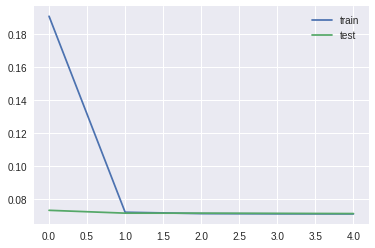

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [0]:
val_preds = siamese_net1.predict([X1_val,X2_val])
train_preds = siamese_net1.predict([X1_train,X2_train])

We transform the predicted values and the real values. The values are between 0 and 1. We will invernse transform them back to 1 - 3 range.

In [0]:
def revertNormalization(val):
  return min_max_scaler.inverse_transform(val.reshape(-1, 1))



In [0]:
real_val_preds = revertNormalization(val_preds)
real_Y_val = revertNormalization(Y_val)

### Validation Results

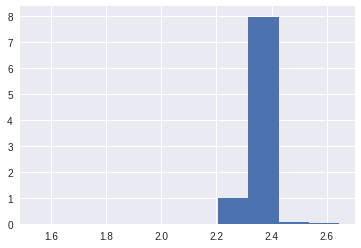

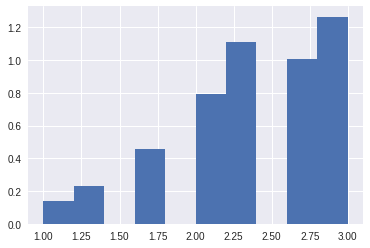

In [35]:

plt.hist(real_val_preds,density=True, histtype='bar')
plt.show()
plt.hist(real_Y_val,density=True, histtype='bar')
plt.show()

We can see that the model predicted values around the average mark.

In [0]:
resultsTable = pd.DataFrame(columns=['model','runtime','TrainRMSE','ValRMSE','TestRMSE','TrainMAE','ValMAE','TestMAE'])

def resetTable():
  resultsTable = pd.DataFrame(columns=['model','runtime','TrainRMSE','ValRMSE','TestRMSE','TrainMAE','ValMAE','TestMAE'])


def addToTable(modelName,runtime,train_rmse,val_rmse,test_rmse,train_mae,val_mae,test_mae):
  return resultsTable.append({'model': modelName,'runtime': runtime,'TrainRMSE': train_rmse,'ValRMSE': val_rmse,
                       'TestRMSE': test_rmse,'TrainMAE': train_mae,'ValMAE' :val_mae,'TestMAE': test_mae},ignore_index=True)
  


Lets run the model on the test samples. In order to do that we need to repeat the preprocessing and the normalization process on the test data set as well.

In [37]:
search_term_chars2 = []
product_description_chars2 = []
search_term_chars2 = mergedTest.search_term.apply(lambda x: search_term_chars2 + list(x))
product_description_chars2 = mergedTest.product_description.apply(lambda x: product_description_chars2 + list(x))
search_term_chars2 = [item for sublist in search_term_chars2 for item in sublist]
product_description_chars2 = [item for sublist in product_description_chars2 for item in sublist]
search_term_char_set2 = sorted(set(search_term_chars2))
product_description_char_set2 = sorted(set(product_description_chars2))

# translate from character to number, it's enumerator
search_term_char_to_int2 = dict((c, i) for i, c in enumerate(search_term_char_set2))
search_term_int_to_char2 = dict((i, c) for i, c in enumerate(search_term_char_set2))
product_description_char_to_int2 = dict((c, i) for i, c in enumerate(product_description_char_set2))
product_description_int_to_char2 = dict((i, c) for i, c in enumerate(product_description_char_set2))

mergedTest.search_term = mergedTest.search_term.apply(lambda x: list(x))
mergedTest.product_description = mergedTest.product_description.apply(lambda x: list(x))

mergedTest.search_term = mergedTest.search_term.apply(lambda x: createData(search_term_char_to_int2, x))
mergedTest.product_description = mergedTest.product_description.apply(lambda x: createData(product_description_char_to_int2, x))
mergedTest.head()

,id,product_uid,product_title,search_term,product_description
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,"[18, 9, 0, 27, 28, 30, 41, 28, 28, 0, 25, 41, ...","[52, 53, 58, 0, 53, 52, 50, 63, 0, 42, 53, 0, ..."
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,"[36, 28, 43, 24, 35, 0, 35, 0, 25, 41, 24, 26,...","[52, 53, 58, 0, 53, 52, 50, 63, 0, 42, 53, 0, ..."
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,"[42, 32, 36, 39, 42, 38, 37, 0, 42, 34, 44, 0,...","[52, 53, 58, 0, 53, 52, 50, 63, 0, 42, 53, 0, ..."
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,"[42, 32, 36, 39, 42, 38, 37, 0, 42, 43, 41, 38...","[52, 53, 58, 0, 53, 52, 50, 63, 0, 42, 53, 0, ..."
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,"[42, 32, 36, 39, 42, 38, 37, 0, 42, 43, 41, 38...","[52, 53, 58, 0, 53, 52, 50, 63, 0, 42, 53, 0, ..."


In [0]:
X1_test = mergedTest.search_term.values
X2_test = mergedTest.product_description.values
X1_test = np.asarray([padding(x,max_length) for x in X1_test])
X2_test = np.asarray([padding(x,max_length) for x in X2_test])
X1_test = X1_test.reshape(X1_test.shape[0],X1_test.shape[1],1)
X2_test = X2_test.reshape(X2_test.shape[0],X2_test.shape[1],1)


In [0]:
test_preds = siamese_net1.predict([X1_test,X2_test])

In [0]:
Y_test = test_sol.relevance.values
Y_test = Y_test.reshape(Y_test.shape[0],1)


### Test Results

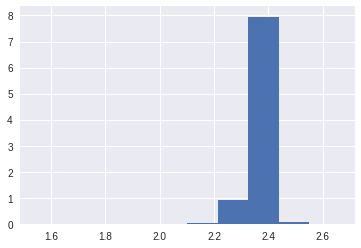

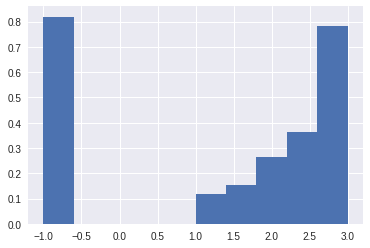

In [41]:

plt.hist(revertNormalization(test_preds),density=True, histtype='bar')
plt.show()
plt.hist(Y_test,density=True, histtype='bar')
plt.show()

In [42]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse


resultsTable = addToTable('CHAR_SiameseNetwork',total_time,
                          mse(revertNormalization(train_preds),revertNormalization(Y_train)),mse(revertNormalization(val_preds),revertNormalization(Y_val)),mse(revertNormalization(test_preds),Y_test),
                          mae(revertNormalization(train_preds),revertNormalization(Y_train)),mae(revertNormalization(val_preds),revertNormalization(Y_val)),mae(revertNormalization(test_preds),Y_test))
resultsTable

,model,runtime,TrainRMSE,ValRMSE,TestRMSE,TrainMAE,ValMAE,TestMAE
0,CHAR_SiameseNetwork,132.153588,0.284046,0.285338,3.954929,0.437019,0.436452,1.40484


We calculated the RMSE and the MAE between the prediction and the true value in each one of the training, validation and test parts of the dataset.
We can see that the test results are not that good. We also notice that there are a lot of samples with relevance -1, this value was not present at the training sample set. This might heavily impact the performance of the models as there is a difference in the distribution of values in the training and the testing sets. We dont want to alter our models based on the testing set so we will continue in the same manner but this special case with -1 relevance value is labeled as 'ignored'. It might be a good idea to include these samples in the training set. 


## ML Benchmark

Lets create a benchmark model to compare the results of our model and the benchmark. We do a similiar character embedding process like in our model, but this time we will use the sklearn Vectorizer to do this process.  The benchmark model that we will use is the Random Forest Regressor.

In [43]:
mergedTrain2 = pd.merge(train, product_descriptions, how='inner', on='product_uid')
mergedTrain2.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...


In [44]:
mergedTest2 = pd.merge(test, product_descriptions, how='inner', on='product_uid')
mergedTest2.head()

,id,product_uid,product_title,search_term,product_description
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"Not only do angles make joints stronger, they ..."
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ..."
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ..."
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ..."
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ..."


In [0]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(encoding='latin-1', analyzer='char')
vectorizer.fit(mergedTrain2['search_term'])

mltrain_x, mlval_x, mltrain_y, mlval_y = train_test_split(mergedTrain2['search_term'].values,mergedTrain2['relevance'].values, test_size = 0.2)
train_x_count =  vectorizer.transform(mltrain_x)
val_x_count =  vectorizer.transform(mlval_x)
test_x_count =  vectorizer.transform(mergedTest2['search_term'].values)


In [46]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm,ensemble

ml = ensemble.RandomForestRegressor()
start_time = time.time()
ml.fit(train_x_count, mltrain_y)
end_time = time.time()
total_time = end_time - start_time

ml_train_preds = ml.predict(train_x_count)
ml_val_preds = ml.predict(val_x_count)
ml_test_preds = ml.predict(test_x_count)



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [47]:
resultsTable = addToTable('CHAR_RandomForestBenchmark',total_time,mse(ml_train_preds,mltrain_y),mse(ml_val_preds,mlval_y),mse(ml_test_preds,Y_test),mae(ml_train_preds,mltrain_y),mae(ml_val_preds,mlval_y),mae(ml_test_preds,Y_test))
resultsTable

,model,runtime,TrainRMSE,ValRMSE,TestRMSE,TrainMAE,ValMAE,TestMAE
0,CHAR_SiameseNetwork,132.153588,0.284046,0.285338,3.954929,0.437019,0.436452,1.404840
1,CHAR_RandomForestBenchmark,46.228773,0.156810,0.230951,4.164663,0.308467,0.377454,1.428889


### Validation Results

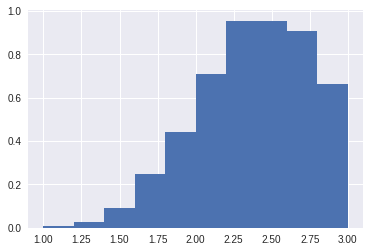

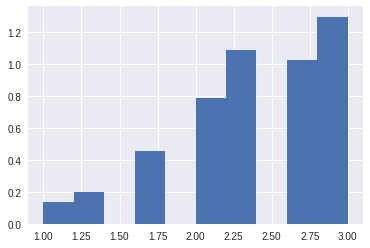

In [48]:
plt.hist(ml_val_preds,density=True, histtype='bar')
plt.show()
plt.hist(mlval_y,density=True, histtype='bar')
plt.show()

### Test Results

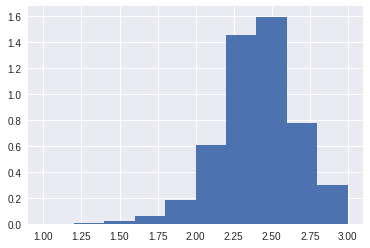

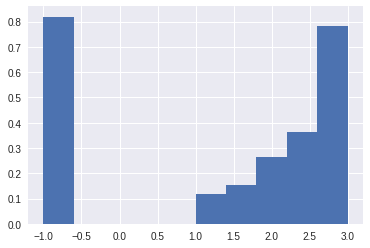

In [49]:
plt.hist(ml_test_preds,density=True, histtype='bar')
plt.show()
plt.hist(Y_test,density=True, histtype='bar')
plt.show()

The benchmark model performed better than our siamese model on train and validation, but a bit worse on the test set. This shows us that our model is not achieving the desired scores to see good enough results.

Here are some possible ways to improve the model:

*   The model is still not tuned with the correct parameters in the intermediate layers. Finding the most percise values for the LSTM node number or the number of outputs in the Dense layer. We tried higher values but it looked like the model was overfitted when it handles large number of LSTM nodes.
*   There might be some imbalance in the data when we pad the search_term and the product_description, the search_term sequences are a lot shorter than the product_description, so we need to chose the right amount of  characters in each sequence or change the value that we pad with in the padding function, currently its 0. 



## Feature Extraction

We want to check how the feature extarction abilities of the model compare by taking out the last layers outputs - the processed search_term and product_description inputs and concatinate that to feed to a ML model to see the RMSE and MAE of the ML models with the features from our network. 
The machine learning we use are the Random Forest model and the SVM from sklearn.

In [50]:

fe_st_input = Input(shape=(max_length,1), name='st_input',dtype='float32')
fe_pd_input = Input(shape=(max_length,1), name='pd_input',dtype='float32')

input_layer1 = siamese_net1.layers[0].input[0]
input_layer2 = siamese_net1.layers[1].input[0]

fe_st_model = createModel()
fe_pd_model = createModel()

output_layer1 = siamese_net1.layers[3].get_output_at(0)
output_layer2 = siamese_net1.layers[3].get_output_at(1)

output_fn = K.function([st_input, pd_input], [output_layer1, output_layer2])
def extractFeatures(model1,model2,customLoss):
  out = concatenate([model1(fe_st_input), model2(fe_pd_input)])
  siamese_net = Model(input=[fe_st_input,fe_pd_input],output=[out])
  siamese_net.load_weights(path + '/best_model_weights_char.h5')
  siamese_net.compile(loss=customLoss,optimizer=Adadelta(lr=1.0, rho=0.95,clipnorm=1.20))
  return siamese_net

fe_model = extractFeatures(fe_st_model,fe_pd_model,'mse')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [0]:
fe_train_features = fe_model.predict([X1_train,X2_train])
fe_val_features = fe_model.predict([X1_val,X2_val])
fe_test_features = fe_model.predict([X1_test,X2_test])

In [52]:

randomForest = ensemble.RandomForestRegressor()
start_time = time.time()
randomForest.fit(fe_train_features, Y_train)
end_time = time.time()
total_time = end_time - start_time


fe_train_preds = randomForest.predict(fe_train_features)
fe_val_preds = randomForest.predict(fe_val_features)
fe_test_preds = randomForest.predict(fe_test_features)

resultsTable = addToTable('FE_RandomForest_CHAR',total_time,
                          mse(revertNormalization(fe_train_preds),revertNormalization(Y_train)),mse(revertNormalization(fe_val_preds),revertNormalization(Y_val)),mse(revertNormalization(fe_test_preds),Y_test),
                          mae(revertNormalization(fe_train_preds),revertNormalization(Y_train)),mae(revertNormalization(fe_val_preds),revertNormalization(Y_val)),mae(revertNormalization(fe_test_preds),Y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [53]:

adaboost = ensemble.AdaBoostRegressor()
start_time = time.time()
adaboost.fit(fe_train_features, Y_train)
end_time = time.time()
total_time = end_time - start_time


fe_train_preds2= adaboost.predict(fe_train_features)
fe_val_preds2 = adaboost.predict(fe_val_features)
fe_test_preds2 = adaboost.predict(fe_test_features)

resultsTable = addToTable('FE_Adaboost_CHAR',total_time,
                          mse(revertNormalization(fe_train_preds2),revertNormalization(Y_train)),mse(revertNormalization(fe_val_preds2),revertNormalization(Y_val)),mse(revertNormalization(fe_test_preds2),Y_test),
                          mae(revertNormalization(fe_train_preds2),revertNormalization(Y_train)),mae(revertNormalization(fe_val_preds2),revertNormalization(Y_val)),mae(revertNormalization(fe_test_preds2),Y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


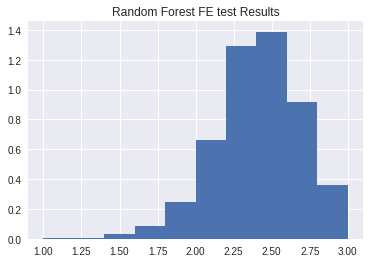

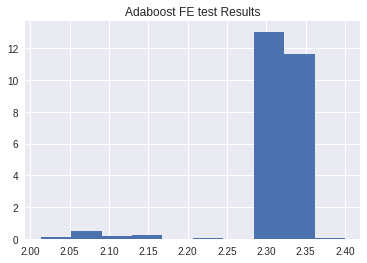

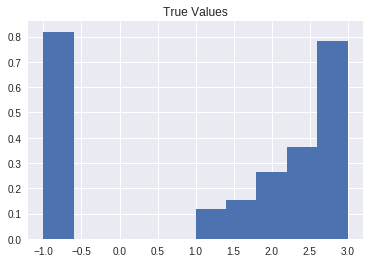

In [54]:
plt.hist(revertNormalization(fe_test_preds),density=True, histtype='bar')
plt.title('Random Forest FE test Results')
plt.show()
plt.hist(revertNormalization(fe_test_preds2),density=True, histtype='bar')
plt.title('Adaboost FE test Results')
plt.show()
plt.hist(Y_test,density=True, histtype='bar')
plt.title('True Values')
plt.show()

In [55]:
resultsTable

,model,runtime,TrainRMSE,ValRMSE,TestRMSE,TrainMAE,ValMAE,TestMAE
0,CHAR_SiameseNetwork,132.153588,0.284046,0.285338,3.954929,0.437019,0.436452,1.404840
1,CHAR_RandomForestBenchmark,46.228773,0.156810,0.230951,4.164663,0.308467,0.377454,1.428889
2,FE_RandomForest_CHAR,6.859185,0.131588,0.242680,4.171411,0.275356,0.386893,1.437754
3,FE_Adaboost_CHAR,2.208713,0.287369,0.288035,3.775366,0.442420,0.440698,1.381365


We see that the feature extraction ML models had pretty much the same performance as the siamese network. This means that the inaccuarcy of our model is in the feature extraction phase, maybe by making the improvements listed above we might acheive a better score.

# Word Level Embedding

We want to repeat the process but this time we want to do the embedding on a word level. Each word, instead of each character as in the last part, will get a unique value in a sequence of values that will be fed to a similiar siamese network and will be checked in the same manner as the character embedding.

## Data Preprocessing

Similiarly we find the amount of unique words that are available for each of the search_term and product_description samples and create dictionaries for each one of them to converts the texts to unique value sequences for the model to train and predict on.

In [56]:
mergedTrain = pd.merge(train, product_descriptions, how='inner', on='product_uid')
mergedTrain.search_term = mergedTrain.search_term.apply(lambda x: x.lower())
mergedTrain.product_description = mergedTrain.product_description.apply(lambda x: x.lower())

mergedTrain.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,behr premium textured deckover is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,update your bathroom with the delta vero singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,update your bathroom with the delta vero singl...


In [57]:
mergedTest= pd.merge(test, product_descriptions, how='inner', on='product_uid')
mergedTest.search_term = mergedTest.search_term.apply(lambda x: x.lower())
mergedTest.product_description = mergedTest.product_description.apply(lambda x: x.lower())

mergedTest.head()

,id,product_uid,product_title,search_term,product_description
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"not only do angles make joints stronger, they ..."
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"not only do angles make joints stronger, they ..."
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"not only do angles make joints stronger, they ..."
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"not only do angles make joints stronger, they ..."
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"not only do angles make joints stronger, they ..."


In [58]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
st_words = []
for term in mergedTrain.search_term.values:
   for word in word_tokenize(term):
      st_words.append(word)
st_word_set = sorted(set(st_words))
st_dict = dict((c, i) for i, c in enumerate(st_word_set))


In [0]:
pd_words = []
for term in mergedTrain.product_description.values:
   for word in word_tokenize(term):
      pd_words.append(word)
pd_word_set = sorted(set(pd_words))
pd_dict = dict((c, i) for i, c in enumerate(pd_word_set))

In [0]:
st_words2 = []
for term in mergedTest.search_term.values:
   for word in word_tokenize(term):
      st_words2.append(word)
st_word_set2 = sorted(set(st_words2))
st_dict2 = dict((c, i) for i, c in enumerate(st_word_set2))

pd_words2 = []
for term in mergedTest.product_description.values:
   for word in word_tokenize(term):
      pd_words2.append(word)
pd_word_set2 = sorted(set(pd_words2))
pd_dict2 = dict((c, i) for i, c in enumerate(pd_word_set2))


In [62]:
mergedTrain.search_term = mergedTrain.search_term.apply(lambda x: createData(st_dict, word_tokenize(x)))
mergedTrain.product_description = mergedTrain.product_description.apply(lambda x: createData(pd_dict, word_tokenize(x)))

mergedTrain.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,"[1199, 1715]",3.00,"[144772, 147036, 70311, 23139, 133460, 119994,..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,"[4486, 1715]",2.50,"[144772, 147036, 70311, 23139, 133460, 119994,..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,"[2657, 5406]",3.00,"[33028, 162291, 206607, 64260, 118454, 22904, ..."
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,"[6037, 6714, 3974]",2.33,"[215988, 230394, 31540, 227925, 206720, 65819,..."
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,"[6714, 5334, 3259]",2.67,"[215988, 230394, 31540, 227925, 206720, 65819,..."


In [63]:
mergedTest.search_term = mergedTest.search_term.apply(lambda x: createData(st_dict2, word_tokenize(x)))
mergedTest.product_description = mergedTest.product_description.apply(lambda x: createData(pd_dict2, word_tokenize(x)))

mergedTest.head()

,id,product_uid,product_title,search_term,product_description
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,"[1552, 4037, 2643]","[208063, 211305, 100927, 32893, 191495, 172146..."
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,"[7344, 6673, 2644]","[208063, 211305, 100927, 32893, 191495, 172146..."
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,"[10001, 10046, 1616]","[208063, 211305, 100927, 32893, 191495, 172146..."
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,"[10001, 10553, 10977]","[208063, 211305, 100927, 32893, 191495, 172146..."
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,"[10001, 10553, 10973, 5880]","[208063, 211305, 100927, 32893, 191495, 172146..."


## Data Normalization

We normalize the target relevance to be in the 0 - 1 range, like in the first part. We try to limit the word sequences to 50 words as in the same manner as characters.

In [64]:
target = mergedTrain['relevance'].values
min_max_scaler = preprocessing.MinMaxScaler()
Y = min_max_scaler.fit_transform(target.reshape(-1, 1))

Y[:5]


array([[1.   ],
       [0.75 ],
       [1.   ],
       [0.665],
       [0.835]])

In [0]:
X1 = mergedTrain['search_term'].values
X2 = mergedTrain['product_description'].values

search_terms_lens = []
for element in mergedTrain['search_term'].values:
    search_terms_lens.append(len(element))
    
product_description_lens = []
for element in mergedTrain['product_description'].values:
    product_description_lens.append(len(element))
    
max_length1 = max(search_terms_lens)
max_length2 = max(product_description_lens)


In [0]:
max_length = 30

def padding(seq, length):
    ans = []
    for i in range(0,min(len(seq),length)):
        ans.append(seq[i])
    if len(seq) <= length:
        for i in range(0,length-len(seq)):
            ans.append(0)
    return ans

X1 = np.asarray([padding(x,max_length) for x in X1])
X2 = np.asarray([padding(x,max_length) for x in X2])
X1 = X1.reshape(X1.shape[0],X1.shape[1],1)
X2 = X2.reshape(X2.shape[0],X2.shape[1],1)

In [0]:
X1_test = mergedTest.search_term.values
X2_test = mergedTest.product_description.values
X1_test = np.asarray([padding(x,max_length) for x in X1_test])
X2_test = np.asarray([padding(x,max_length) for x in X2_test])
X1_test = X1_test.reshape(X1_test.shape[0],X1_test.shape[1],1)
X2_test = X2_test.reshape(X2_test.shape[0],X2_test.shape[1],1)

## Model Fitting + Predictions

The model is created in the same manner as in the first part. the only difference is that the input now are embedded word sequences of the data samples.

In [0]:
def set_callbacks2(description='run1',patience=15,tb_base_logdir='./logs/'):
    cp = ModelCheckpoint(path + '/best_model_weights_word.h5'.format(description),save_best_only=True)
    rlop = ReduceLROnPlateau(patience=5)   
    cb = [cp,rlop]
    return cb

In [69]:
st_input = Input(shape=(max_length,1), name='st_input')
pd_input = Input(shape=(max_length,1), name='pd_input')


def createModel():
    model = Sequential()
    model.add(LSTM(40))
    model.add(Dense(40, activation='relu'))
    return model
  
st_model3 = createModel()
pd_model3 = createModel()


def createSiameseModel(model1,model2,customLoss):
  out = Lambda(function=lambda x: K.exp(-K.sum(K.abs(x[0]-x[1]), axis=1, keepdims=True)),
                output_shape=lambda x: (x[0][0], 1),
                name='prediction')([model1(st_input), model2(pd_input)])
  siamese_net = Model(input=[st_input,pd_input],output=[out])
  siamese_net.compile(loss=customLoss,optimizer=Adadelta(lr=1.0, rho=0.95,clipnorm=1.20))
  return siamese_net

siamese_net3 = createSiameseModel(st_model3,pd_model3,'mse')
siamese_net4 = createSiameseModel(st_model3,pd_model3,'mae')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [70]:
siamese_net3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
st_input (InputLayer)           (None, 30, 1)        0                                            
__________________________________________________________________________________________________
pd_input (InputLayer)           (None, 30, 1)        0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 40)           8360        st_input[0][0]                   
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 40)           8360        pd_input[0][0]                   
__________________________________________________________________________________________________
prediction

In [71]:
X1_train,X1_val,X2_train,X2_val,Y_train, Y_val = train_test_split(X1,X2,Y,test_size = 0.2)

start = time.time()
history3 = siamese_net3.fit([X1_train,X2_train],Y_train,batch_size=1024, epochs=5, verbose=1, validation_data=([X1_val,X2_val],Y_val), callbacks=set_callbacks2())
end = time.time()
total_time = end - start

Train on 59253 samples, validate on 14814 samples
Epoch 1/5
59253/59253 [==============================] - 17s 284us/step - loss: 0.2280 - val_loss: 0.0912
Epoch 2/5
59253/59253 [==============================] - 15s 259us/step - loss: 0.0794 - val_loss: 0.0724
Epoch 3/5
59253/59253 [==============================] - 15s 252us/step - loss: 0.0715 - val_loss: 0.0722
Epoch 4/5
59253/59253 [==============================] - 15s 253us/step - loss: 0.0715 - val_loss: 0.0743
Epoch 5/5
59253/59253 [==============================] - 15s 253us/step - loss: 0.0715 - val_loss: 0.0713


In [0]:
val_preds = siamese_net3.predict([X1_val,X2_val])
train_preds = siamese_net3.predict([X1_train,X2_train])
test_preds = siamese_net3.predict([X1_test,X2_test])

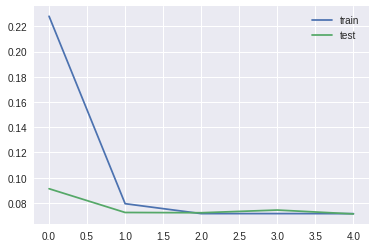

In [73]:
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='test')
plt.legend()
plt.show()


### Validation Results

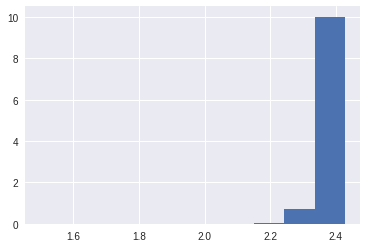

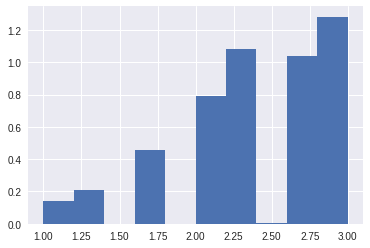

In [74]:

plt.hist(revertNormalization(val_preds),density=True, histtype='bar')
plt.show()
plt.hist(revertNormalization(Y_val),density=True, histtype='bar')
plt.show()

### Test Results

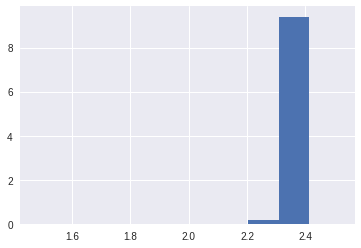

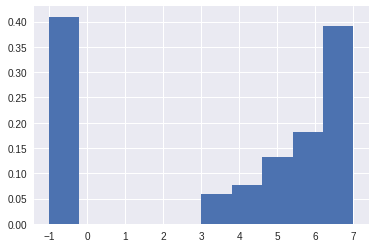

In [75]:

plt.hist(revertNormalization(test_preds),density=True, histtype='bar')
plt.show()
plt.hist(revertNormalization(Y_test),density=True, histtype='bar')
plt.show()

In [76]:
resultsTable = addToTable('WORD_SiameseNetwork',total_time,
                          mse(revertNormalization(train_preds),revertNormalization(Y_train)),mse(revertNormalization(val_preds),revertNormalization(Y_val)),mse(revertNormalization(test_preds),Y_test)
                          ,mae(revertNormalization(train_preds),revertNormalization(Y_train)),mae(revertNormalization(val_preds),revertNormalization(Y_val)),mae(revertNormalization(test_preds),Y_test))
resultsTable

,model,runtime,TrainRMSE,ValRMSE,TestRMSE,TrainMAE,ValMAE,TestMAE
0,CHAR_SiameseNetwork,132.153588,0.284046,0.285338,3.954929,0.437019,0.436452,1.404840
1,CHAR_RandomForestBenchmark,46.228773,0.156810,0.230951,4.164663,0.308467,0.377454,1.428889
2,FE_RandomForest_CHAR,6.859185,0.131588,0.242680,4.171411,0.275356,0.386893,1.437754
3,FE_Adaboost_CHAR,2.208713,0.287369,0.288035,3.775366,0.442420,0.440698,1.381365
4,WORD_SiameseNetwork,81.938102,0.285369,0.285096,3.887307,0.435509,0.435625,1.393851


We see that the word model outperformed the character model, but only by a little bit. 

## Feature Extraction - Word Level

Again, we want to check our feature extraction capabilites of the word model by feeding the features that the model finds to classic ML models to see their performance with the processed data that our model creates during the learning phase.

In [77]:
fe_st_input = Input(shape=(max_length,1), name='st_input',dtype='float32')
fe_pd_input = Input(shape=(max_length,1), name='pd_input',dtype='float32')

input_layer1 = siamese_net1.layers[0].input[0]
input_layer2 = siamese_net1.layers[1].input[0]

fe_st_model = createModel()
fe_pd_model = createModel()

output_layer1 = siamese_net1.layers[3].get_output_at(0)
output_layer2 = siamese_net1.layers[3].get_output_at(1)

output_fn = K.function([st_input, pd_input], [output_layer1, output_layer2])
def extractFeatures(model1,model2,customLoss):
  out = concatenate([model1(fe_st_input), model2(fe_pd_input)])
  siamese_net = Model(input=[fe_st_input,fe_pd_input],output=[out])
  siamese_net.load_weights(path + '/best_model_weights_word.h5')
  siamese_net.compile(loss=customLoss,optimizer=Adadelta(lr=1.0, rho=0.95,clipnorm=1.20))
  return siamese_net

fe_model = extractFeatures(fe_st_model,fe_pd_model,'mse')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  app.launch_new_instance()


In [0]:
fe_train_features = fe_model.predict([X1_train,X2_train])
fe_val_features = fe_model.predict([X1_val,X2_val])
fe_test_features = fe_model.predict([X1_test,X2_test])

In [79]:

randomForest2 = ensemble.RandomForestRegressor()
start_time = time.time()
randomForest2.fit(fe_train_features, Y_train)
end_time = time.time()
total_time = end_time - start_time


fe_train_preds = randomForest2.predict(fe_train_features)
fe_val_preds = randomForest2.predict(fe_val_features)
fe_test_preds = randomForest2.predict(fe_test_features)

resultsTable = addToTable('FE_RandomForest_WORD',total_time,
                          mse(revertNormalization(fe_train_preds),revertNormalization(Y_train)),mse(revertNormalization(fe_val_preds),revertNormalization(Y_val)),mse(revertNormalization(fe_test_preds),Y_test),
                          mae(revertNormalization(fe_train_preds),revertNormalization(Y_train)),mae(revertNormalization(fe_val_preds),revertNormalization(Y_val)),mae(revertNormalization(fe_test_preds),Y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [80]:

adaboost2 = ensemble.AdaBoostRegressor()
start_time = time.time()
adaboost2.fit(fe_train_features, Y_train)
end_time = time.time()
total_time = end_time - start_time


fe_train_preds2= adaboost2.predict(fe_train_features)
fe_val_preds2 = adaboost2.predict(fe_val_features)
fe_test_preds2 = adaboost2.predict(fe_test_features)

resultsTable = addToTable('FE_AdaBoostRegressor_WORD',total_time,
                          mse(revertNormalization(fe_train_preds2),revertNormalization(Y_train)),mse(revertNormalization(fe_val_preds2),revertNormalization(Y_val)),mse(revertNormalization(fe_test_preds2),Y_test),
                          mae(revertNormalization(fe_train_preds2),revertNormalization(Y_train)),mae(revertNormalization(fe_val_preds2),revertNormalization(Y_val)),mae(revertNormalization(fe_test_preds2),Y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


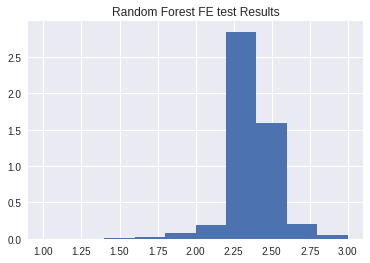

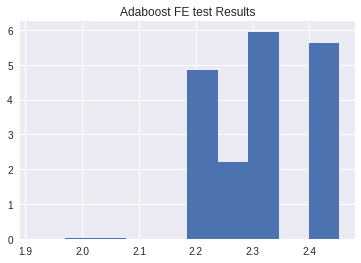

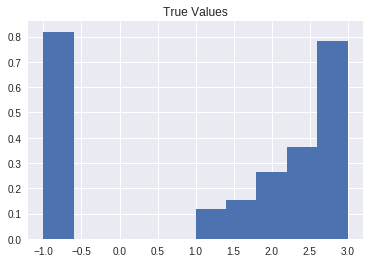

In [82]:
plt.hist(revertNormalization(fe_test_preds),density=True, histtype='bar')
plt.title('Random Forest FE test Results')
plt.show()
plt.hist(revertNormalization(fe_test_preds2),density=True, histtype='bar')
plt.title('Adaboost FE test Results')
plt.show()
plt.hist(Y_test,density=True, histtype='bar')
plt.title('True Values')
plt.show()

In [83]:
resultsTable

,model,runtime,TrainRMSE,ValRMSE,TestRMSE,TrainMAE,ValMAE,TestMAE
0,CHAR_SiameseNetwork,132.153588,0.284046,0.285338,3.954929,0.437019,0.436452,1.404840
1,CHAR_RandomForestBenchmark,46.228773,0.156810,0.230951,4.164663,0.308467,0.377454,1.428889
2,FE_RandomForest_CHAR,6.859185,0.131588,0.242680,4.171411,0.275356,0.386893,1.437754
3,FE_Adaboost_CHAR,2.208713,0.287369,0.288035,3.775366,0.442420,0.440698,1.381365
4,WORD_SiameseNetwork,81.938102,0.285369,0.285096,3.887307,0.435509,0.435625,1.393851
5,FE_RandomForest_WORD,3.425977,0.251777,0.272166,4.025584,0.405640,0.425316,1.416301
6,FE_AdaBoostRegressor_WORD,2.209754,0.284438,0.283751,3.812905,0.443557,0.442999,1.387966


## Test results submission

In [0]:
subans = test_preds.reshape(test_preds.shape[0])


In [0]:
subans = min_max_scaler.inverse_transform(subans.reshape(1, -1))
subans = subans.reshape(subans.shape[1])

In [86]:
subans

array([2.3582325, 2.3582327, 2.3581476, ..., 2.3682241, 2.363795 ,
       2.3512778], dtype=float32)

In [87]:
sub = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/input/sample_submission.csv")
sub.reset_index(drop = True)
print(sub.relevance.values.shape)
sub['relevance'] = subans
sub.to_csv(path + '/sub.csv')

(166693,)


# Summary

To conclude our research, we did see that the word model was slightly better than the character model we created using the siamese network. 
We made some attempts to tune the parameters of both the char and word models but we didnt get significant improvements. The difference of the relevance value between the training and testing sets was impactful to the results as the sets have different value distribution. The feature extraction part helped us identify that the problem is in the feature extraction part of our model. We tried different options on the unification of the 2 branches of the model, as concationation or averaging the results was proven not as good as the negative Manhattan distance. 

We did submit our results on the test set to the Kaggle competitioמ as a late submission in order to get some indication regarding the results we got. The RMSE we got was 0.55, while the best score in the leaderboard is 0.43192.
